<a href="https://colab.research.google.com/github/uday96/EVA4-TSAI/blob/master/S9/EVA4_S9_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data augmentation using albumentations and Grad Cam implementation

Import required modules

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
os.chdir('drive/My Drive/EVA S11')
!ls

'Accuracy curves.png'		 gradcam_incorrect_1_truck.png
 config.py			 gradcam_incorrect_2_car.png
 correct_imgs.png		 gradcam_incorrect_2_plane.png
 data				 gradcam_incorrect_3_car.png
 EVA4_S9_Quiz.ipynb		 gradcam_incorrect_3_dog.png
 EVA4_S9_Solution.ipynb		 gradcam_incorrect_4_cat.png
 gradcam			 gradcam_incorrect_4_frog.png
 gradcam_correct_0_car.png	 images
 gradcam_correct_0_frog.png	 lr_finder.py
 gradcam_correct_1_bird.png	 misclassified_imgs.png
 gradcam_correct_1_car.png	 models
 gradcam_correct_2_bird.png	 __pycache__
 gradcam_correct_2_car.png	 README.md
 gradcam_correct_3_car.png	 results.py
 gradcam_correct_4_car.png	 test.py
 gradcam_correct_4_truck.png	 train.py
 gradcam_incorrect_0_deer.png	 utils.py
 gradcam_incorrect_0_horse.png	 val_accuracy_change.png
 gradcam_incorrect_1_horse.png	 val_loss_change.png


In [13]:
!pip install albumentations==0.4.5

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

from data.data_engine import DataEngine
from config import ModelConfig
from models.resnet import ResNet18

from train import train
from test import test
from results import plot_images, plot_graph
from utils import *
from gradcam.visualize import VisualizeCam

In [0]:
from lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

## Model Configuration and Set Seed

View model configuration and set the seed

In [16]:
# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout': 0.15,
  'epochs': 50,
  'l1_decay': 3e-06,
  'l2_decay': 0.001,
  'lr': 0.1,
  'max_lr': 0.01,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available


## Data Loading and Visualization

Preprocess and load the cifar10 dataset. Visualise the dataset.

Files already downloaded and verified
Files already downloaded and verified
plane   dog  deer  deer


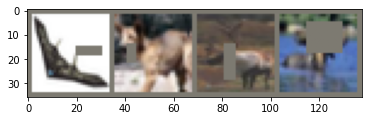

In [17]:
data = DataEngine(args)

# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

In [43]:
from models.resnet_new import NetCifar10
from lr_test.lr_range_test import LRRangeFinder
from lr_test.lr_cycle_plot import LRCyclePlot

  pip install torch-lr-finder -v --global-option="amp"


## Model

Create model and display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
        LayerBlock-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,456
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



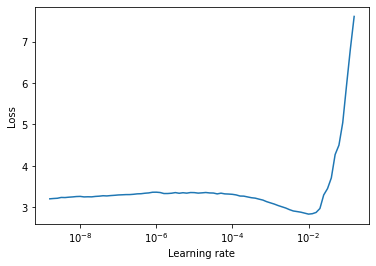

In [20]:

 
device = which_device()

net = NetCifar10()

model = net.to(device)
#optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
show_model_summary(model, (3,32,32))





Learning rate search finished. See the graph with {finder_name}.plot()


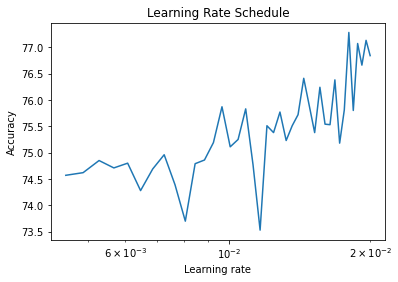

In [44]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
lr_finder = LRRangeFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(data.train_loader, val_loader=data.test_loader, start_lr=1e-4, end_lr=0.02,
                     epochs=50, step_mode="linear")
lr_finder.plot(metric='acc', skip_start=10, skip_end=0)
lr_finder.reset()

In [45]:

best_acc = lr_finder.best_acc
best_lr = lr_finder.history["lr"][lr_finder.history["acc"].index(best_acc)]
print("Best Accuracy: %s\nBest Learning Rate: %s" % (best_acc, best_lr))

Best Accuracy: 77.28
Best Learning Rate: 0.01801050895140665


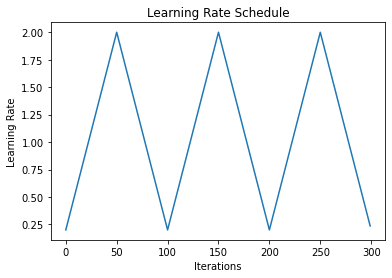

<Figure size 432x288 with 0 Axes>

In [46]:

import numpy as np
from math import floor

class LRCyclePlot(object):
	"""docstring for LRCyclePlot"""
	def __init__(self, arg):
		super(LRCyclePlot, self).__init__()
		self.iterations = arg.get("iterations", 300)
		self.lr_max = arg.get("lr_max", 2)
		self.lr_min = self.lr_max / 10
		self.step_size = arg.get("step_size", 50)
		self.cycle_size = self.step_size * 2

	def _calc_lr(self, curr_iter):
		cycle = floor(1 + curr_iter/self.cycle_size)
		x = abs(curr_iter/self.step_size - (2 * cycle) + 1)
		lr_t = self.lr_min + (self.lr_max - self.lr_min)*(1 - x)
		return lr_t

	def __call__(self, fname):
		lr_trend = []
		for x in range(self.iterations):
			lr_trend.append(self._calc_lr(x))

		plt.plot(lr_trend)
		plt.title(f'Learning Rate Schedule')
		plt.xlabel('Iterations')
		plt.ylabel('Learning Rate')

		plt.show()
		plt.savefig(fname)

if __name__ == '__main__':
	lrplt = LRCyclePlot({})
	lrplt("lr_cycle_plot_test.png")


## Training and Testing

Train the model and evaluate it

In [47]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(data.train_loader),
                       epochs=args.epochs, div_factor=10, final_div_factor=1,
                       pct_start=5/args.epochs, anneal_strategy="linear")

test_losses, train_losses, test_accs, train_accs = [], [], [], []
misclassified_imgs, correct_imgs = [], []
lr_trend = []
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(args.epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, epoch==args.epochs-1)

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.001801)


L2_loss=393.3592834472656 L1_loss=38596.29296875 Loss=1.2002830505371094 Batch_id=781 Accuracy=69.79: 100%|██████████| 782/782 [01:21<00:00,  9.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0118, Accuracy: 7379/10000 (73.79%)

EPOCH: 2 (LR: 0.005044)


L2_loss=392.1135559082031 L1_loss=38491.32421875 Loss=1.3921200037002563 Batch_id=781 Accuracy=69.48: 100%|██████████| 782/782 [01:21<00:00,  9.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0121, Accuracy: 7367/10000 (73.67%)

EPOCH: 3 (LR: 0.008286)


L2_loss=390.7785339355469 L1_loss=38376.3671875 Loss=1.3916414976119995 Batch_id=781 Accuracy=69.55: 100%|██████████| 782/782 [01:21<00:00,  9.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0120, Accuracy: 7330/10000 (73.30%)

EPOCH: 4 (LR: 0.011529)


L2_loss=389.4244689941406 L1_loss=38257.1796875 Loss=1.2565747499465942 Batch_id=781 Accuracy=69.62: 100%|██████████| 782/782 [01:21<00:00,  9.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0121, Accuracy: 7293/10000 (72.93%)

EPOCH: 5 (LR: 0.014772)


L2_loss=387.857666015625 L1_loss=38135.3984375 Loss=1.3885506391525269 Batch_id=781 Accuracy=69.39: 100%|██████████| 782/782 [01:21<00:00,  9.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0122, Accuracy: 7306/10000 (73.06%)

EPOCH: 6 (LR: 0.018010)


L2_loss=386.4480895996094 L1_loss=38007.9453125 Loss=1.1035680770874023 Batch_id=781 Accuracy=69.67: 100%|██████████| 782/782 [01:21<00:00,  9.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0117, Accuracy: 7388/10000 (73.88%)

EPOCH: 7 (LR: 0.017650)


L2_loss=385.0313720703125 L1_loss=37882.2578125 Loss=1.3832063674926758 Batch_id=781 Accuracy=69.90: 100%|██████████| 782/782 [01:21<00:00,  9.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0114, Accuracy: 7482/10000 (74.82%)

EPOCH: 8 (LR: 0.017290)


L2_loss=383.624755859375 L1_loss=37764.5625 Loss=2.332883596420288 Batch_id=781 Accuracy=69.76: 100%|██████████| 782/782 [01:21<00:00,  9.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0118, Accuracy: 7387/10000 (73.87%)

EPOCH: 9 (LR: 0.016929)


L2_loss=382.3573913574219 L1_loss=37642.71875 Loss=1.4135925769805908 Batch_id=781 Accuracy=70.01: 100%|██████████| 782/782 [01:21<00:00,  9.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0116, Accuracy: 7464/10000 (74.64%)

EPOCH: 10 (LR: 0.016569)


L2_loss=381.06536865234375 L1_loss=37529.73828125 Loss=1.2517094612121582 Batch_id=781 Accuracy=70.28: 100%|██████████| 782/782 [01:21<00:00,  9.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0121, Accuracy: 7371/10000 (73.71%)

EPOCH: 11 (LR: 0.016209)


L2_loss=379.8566589355469 L1_loss=37412.96484375 Loss=1.3719072341918945 Batch_id=781 Accuracy=70.45: 100%|██████████| 782/782 [01:21<00:00,  9.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0116, Accuracy: 7476/10000 (74.76%)

EPOCH: 12 (LR: 0.015849)


L2_loss=378.584716796875 L1_loss=37307.18359375 Loss=0.9355347752571106 Batch_id=781 Accuracy=70.61: 100%|██████████| 782/782 [01:21<00:00,  9.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0114, Accuracy: 7463/10000 (74.63%)

EPOCH: 13 (LR: 0.015489)


L2_loss=377.3363037109375 L1_loss=37204.47265625 Loss=0.7852386236190796 Batch_id=781 Accuracy=70.61: 100%|██████████| 782/782 [01:21<00:00,  9.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0117, Accuracy: 7448/10000 (74.48%)

EPOCH: 14 (LR: 0.015128)


L2_loss=376.2253112792969 L1_loss=37106.921875 Loss=1.18797767162323 Batch_id=781 Accuracy=71.26: 100%|██████████| 782/782 [01:21<00:00,  9.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0113, Accuracy: 7505/10000 (75.05%)

EPOCH: 15 (LR: 0.014768)


L2_loss=375.14324951171875 L1_loss=37011.90625 Loss=1.417472004890442 Batch_id=781 Accuracy=70.93: 100%|██████████| 782/782 [01:21<00:00,  9.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0110, Accuracy: 7555/10000 (75.55%)

EPOCH: 16 (LR: 0.014408)


L2_loss=373.9844055175781 L1_loss=36915.7421875 Loss=1.3592555522918701 Batch_id=781 Accuracy=71.14: 100%|██████████| 782/782 [01:21<00:00,  9.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0117, Accuracy: 7421/10000 (74.21%)

EPOCH: 17 (LR: 0.014048)


L2_loss=372.93341064453125 L1_loss=36822.9765625 Loss=1.2635318040847778 Batch_id=781 Accuracy=71.68: 100%|██████████| 782/782 [01:21<00:00,  9.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0112, Accuracy: 7558/10000 (75.58%)

EPOCH: 18 (LR: 0.013688)


L2_loss=371.7073669433594 L1_loss=36734.50390625 Loss=0.9865345358848572 Batch_id=781 Accuracy=72.10: 100%|██████████| 782/782 [01:21<00:00,  9.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0111, Accuracy: 7526/10000 (75.26%)

EPOCH: 19 (LR: 0.013327)


L2_loss=370.7989501953125 L1_loss=36651.29296875 Loss=1.2795242071151733 Batch_id=781 Accuracy=71.62: 100%|██████████| 782/782 [01:21<00:00,  9.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0115, Accuracy: 7446/10000 (74.46%)

EPOCH: 20 (LR: 0.012967)


L2_loss=369.8328857421875 L1_loss=36559.46875 Loss=1.8994216918945312 Batch_id=781 Accuracy=72.13: 100%|██████████| 782/782 [01:21<00:00,  9.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0111, Accuracy: 7574/10000 (75.74%)

EPOCH: 21 (LR: 0.012607)


L2_loss=368.8700866699219 L1_loss=36478.6484375 Loss=1.2364869117736816 Batch_id=781 Accuracy=71.96: 100%|██████████| 782/782 [01:21<00:00,  9.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0118, Accuracy: 7353/10000 (73.53%)

EPOCH: 22 (LR: 0.012247)


L2_loss=367.9389343261719 L1_loss=36398.0703125 Loss=2.3206260204315186 Batch_id=781 Accuracy=72.48: 100%|██████████| 782/782 [01:21<00:00,  9.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0108, Accuracy: 7635/10000 (76.35%)

EPOCH: 23 (LR: 0.011886)


L2_loss=367.08984375 L1_loss=36328.58203125 Loss=1.6093274354934692 Batch_id=781 Accuracy=72.37: 100%|██████████| 782/782 [01:21<00:00,  9.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0110, Accuracy: 7592/10000 (75.92%)

EPOCH: 24 (LR: 0.011526)


L2_loss=366.17071533203125 L1_loss=36259.46484375 Loss=1.318869948387146 Batch_id=781 Accuracy=72.69: 100%|██████████| 782/782 [01:21<00:00,  9.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0116, Accuracy: 7506/10000 (75.06%)

EPOCH: 25 (LR: 0.011166)


L2_loss=365.2816162109375 L1_loss=36187.34765625 Loss=1.2182022333145142 Batch_id=781 Accuracy=72.70: 100%|██████████| 782/782 [01:20<00:00,  9.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0109, Accuracy: 7615/10000 (76.15%)

EPOCH: 26 (LR: 0.010806)


L2_loss=364.38006591796875 L1_loss=36118.484375 Loss=1.0341172218322754 Batch_id=781 Accuracy=72.90: 100%|██████████| 782/782 [01:20<00:00,  9.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0106, Accuracy: 7651/10000 (76.51%)

EPOCH: 27 (LR: 0.010446)


L2_loss=363.61651611328125 L1_loss=36045.94921875 Loss=1.9597535133361816 Batch_id=781 Accuracy=73.01: 100%|██████████| 782/782 [01:20<00:00,  9.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0114, Accuracy: 7511/10000 (75.11%)

EPOCH: 28 (LR: 0.010085)


L2_loss=362.7513732910156 L1_loss=35977.5546875 Loss=1.000739336013794 Batch_id=781 Accuracy=73.23: 100%|██████████| 782/782 [01:20<00:00,  9.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0108, Accuracy: 7633/10000 (76.33%)

EPOCH: 29 (LR: 0.009725)


L2_loss=361.8991394042969 L1_loss=35911.0 Loss=2.131483554840088 Batch_id=781 Accuracy=73.42: 100%|██████████| 782/782 [01:21<00:00,  9.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0108, Accuracy: 7640/10000 (76.40%)

EPOCH: 30 (LR: 0.009365)


L2_loss=361.1082763671875 L1_loss=35850.48046875 Loss=1.3373788595199585 Batch_id=781 Accuracy=73.66: 100%|██████████| 782/782 [01:21<00:00,  9.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0105, Accuracy: 7702/10000 (77.02%)

EPOCH: 31 (LR: 0.009005)


L2_loss=360.284423828125 L1_loss=35787.61328125 Loss=1.5714190006256104 Batch_id=781 Accuracy=73.52: 100%|██████████| 782/782 [01:20<00:00,  9.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0108, Accuracy: 7637/10000 (76.37%)

EPOCH: 32 (LR: 0.008645)


L2_loss=359.59112548828125 L1_loss=35734.4765625 Loss=1.4336084127426147 Batch_id=781 Accuracy=73.72: 100%|██████████| 782/782 [01:20<00:00,  9.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0111, Accuracy: 7553/10000 (75.53%)

EPOCH: 33 (LR: 0.008284)


L2_loss=358.8747253417969 L1_loss=35672.90234375 Loss=1.1046533584594727 Batch_id=781 Accuracy=74.12: 100%|██████████| 782/782 [01:21<00:00,  9.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0106, Accuracy: 7706/10000 (77.06%)

EPOCH: 34 (LR: 0.007924)


L2_loss=358.0635986328125 L1_loss=35615.796875 Loss=1.248516321182251 Batch_id=781 Accuracy=74.00: 100%|██████████| 782/782 [01:20<00:00,  9.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0105, Accuracy: 7661/10000 (76.61%)

EPOCH: 35 (LR: 0.007564)


L2_loss=357.48944091796875 L1_loss=35562.55859375 Loss=1.09027099609375 Batch_id=781 Accuracy=74.60: 100%|██████████| 782/782 [01:20<00:00,  9.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0103, Accuracy: 7766/10000 (77.66%)

EPOCH: 36 (LR: 0.007204)


L2_loss=356.7744445800781 L1_loss=35507.96484375 Loss=1.3551673889160156 Batch_id=781 Accuracy=74.32: 100%|██████████| 782/782 [01:20<00:00,  9.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0105, Accuracy: 7713/10000 (77.13%)

EPOCH: 37 (LR: 0.006844)


L2_loss=356.025634765625 L1_loss=35455.9453125 Loss=1.3597382307052612 Batch_id=781 Accuracy=74.54: 100%|██████████| 782/782 [01:20<00:00,  9.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0103, Accuracy: 7775/10000 (77.75%)

EPOCH: 38 (LR: 0.006483)


L2_loss=355.35308837890625 L1_loss=35406.97265625 Loss=1.5942538976669312 Batch_id=781 Accuracy=74.74: 100%|██████████| 782/782 [01:20<00:00,  9.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0104, Accuracy: 7747/10000 (77.47%)

EPOCH: 39 (LR: 0.006123)


L2_loss=354.7281188964844 L1_loss=35355.859375 Loss=1.4076876640319824 Batch_id=781 Accuracy=74.95: 100%|██████████| 782/782 [01:21<00:00,  9.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0102, Accuracy: 7766/10000 (77.66%)

EPOCH: 40 (LR: 0.005763)


L2_loss=354.1097717285156 L1_loss=35300.13671875 Loss=1.168826699256897 Batch_id=781 Accuracy=75.11: 100%|██████████| 782/782 [01:21<00:00,  9.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0104, Accuracy: 7759/10000 (77.59%)

EPOCH: 41 (LR: 0.005403)


L2_loss=353.47344970703125 L1_loss=35251.515625 Loss=1.0364550352096558 Batch_id=781 Accuracy=75.10: 100%|██████████| 782/782 [01:21<00:00,  9.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0102, Accuracy: 7788/10000 (77.88%)

EPOCH: 42 (LR: 0.005042)


L2_loss=352.8002624511719 L1_loss=35204.51171875 Loss=0.8910322189331055 Batch_id=781 Accuracy=75.41: 100%|██████████| 782/782 [01:21<00:00,  9.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0101, Accuracy: 7834/10000 (78.34%)

EPOCH: 43 (LR: 0.004682)


L2_loss=352.2568359375 L1_loss=35158.046875 Loss=1.1023861169815063 Batch_id=781 Accuracy=75.31: 100%|██████████| 782/782 [01:21<00:00,  9.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0101, Accuracy: 7827/10000 (78.27%)

EPOCH: 44 (LR: 0.004322)


L2_loss=351.69464111328125 L1_loss=35112.359375 Loss=1.2921946048736572 Batch_id=781 Accuracy=75.83: 100%|██████████| 782/782 [01:21<00:00,  9.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0101, Accuracy: 7821/10000 (78.21%)

EPOCH: 45 (LR: 0.003962)


L2_loss=351.18695068359375 L1_loss=35062.68359375 Loss=1.1525956392288208 Batch_id=781 Accuracy=76.35: 100%|██████████| 782/782 [01:20<00:00,  9.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0100, Accuracy: 7860/10000 (78.60%)

EPOCH: 46 (LR: 0.003602)


L2_loss=350.7129821777344 L1_loss=35015.6640625 Loss=0.9892040491104126 Batch_id=781 Accuracy=76.28: 100%|██████████| 782/782 [01:20<00:00,  9.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0104, Accuracy: 7763/10000 (77.63%)

EPOCH: 47 (LR: 0.003241)


L2_loss=350.0956726074219 L1_loss=34971.01171875 Loss=1.3972704410552979 Batch_id=781 Accuracy=76.54: 100%|██████████| 782/782 [01:20<00:00,  9.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0099, Accuracy: 7878/10000 (78.78%)

EPOCH: 48 (LR: 0.002881)


L2_loss=349.5764465332031 L1_loss=34928.6640625 Loss=1.1884047985076904 Batch_id=781 Accuracy=76.82: 100%|██████████| 782/782 [01:21<00:00,  9.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0102, Accuracy: 7786/10000 (77.86%)

EPOCH: 49 (LR: 0.002521)


L2_loss=349.0715637207031 L1_loss=34887.1640625 Loss=0.9627920389175415 Batch_id=781 Accuracy=76.85: 100%|██████████| 782/782 [01:21<00:00,  9.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0098, Accuracy: 7895/10000 (78.95%)

EPOCH: 50 (LR: 0.002161)


L2_loss=348.6463623046875 L1_loss=34848.0859375 Loss=1.8021423816680908 Batch_id=781 Accuracy=76.94: 100%|██████████| 782/782 [01:21<00:00,  9.65it/s]


Test set: Average loss: 0.0098, Accuracy: 7923/10000 (79.23%)



## Plot Validation Accuracy

Plot the change in validation accracy vs epochs

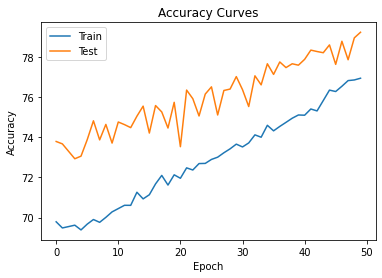

In [48]:


fig, ax = plt.subplots()

ax.plot(train_accs,label='Train')
ax.plot(test_accs, label='Test')

plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

## Misclassified Images

Display 25 misclassified test images

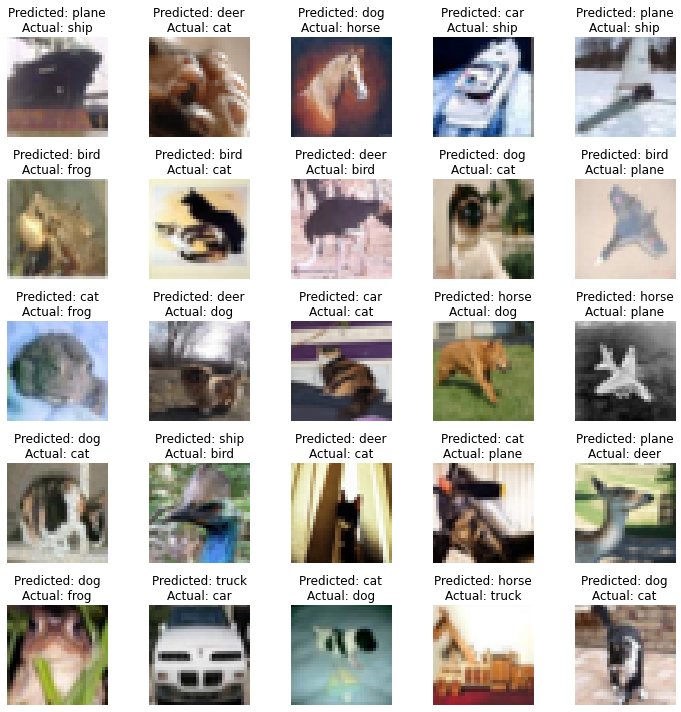

In [49]:
plot_images(misclassified_imgs, data.classes, "misclassified_imgs.png")

## Visualize GradCam

Use GradCam to understand where the network is looking at while prediction

In [0]:
target_layers = ["layer1","layer2","layer3"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

### GradCam for correctly classified images

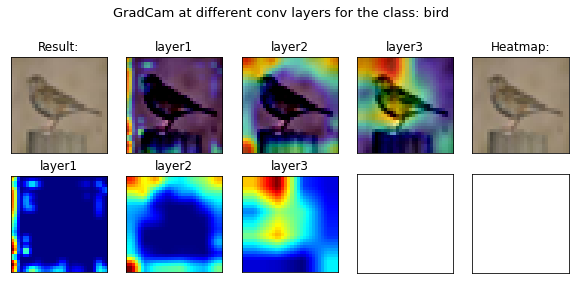

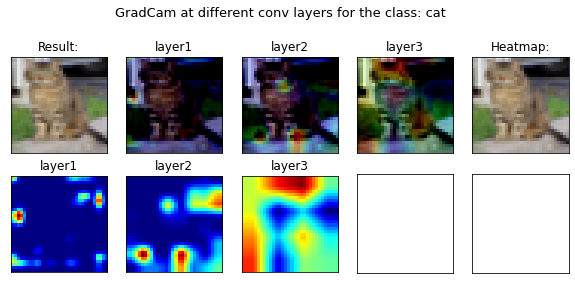

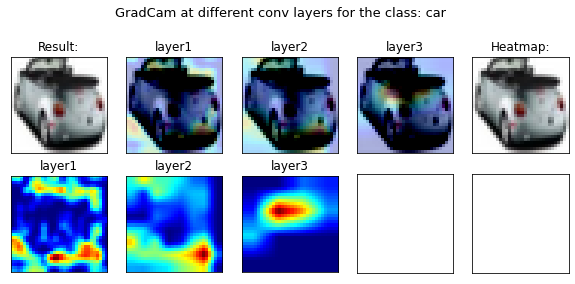

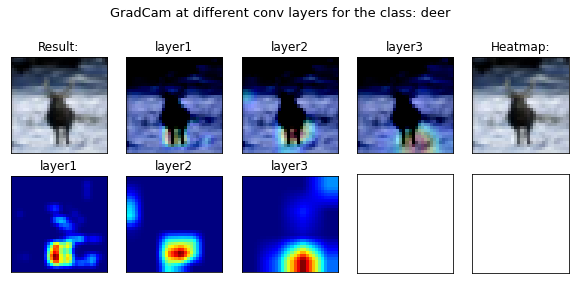

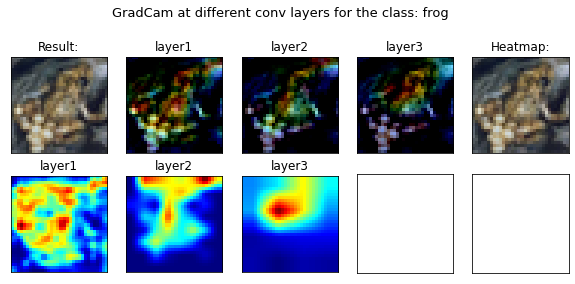

In [51]:
num_img = 5
correct_pred_imgs = []
for i in range(num_img):
  correct_pred_imgs.append(torch.as_tensor(correct_imgs[i]["img"]))
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="correct")

### GradCam for incorrectly classified images

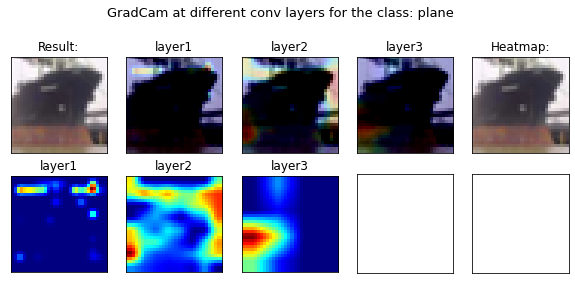

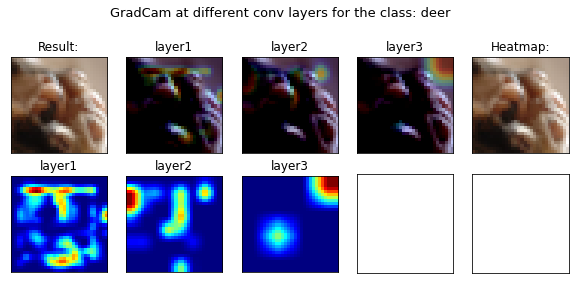

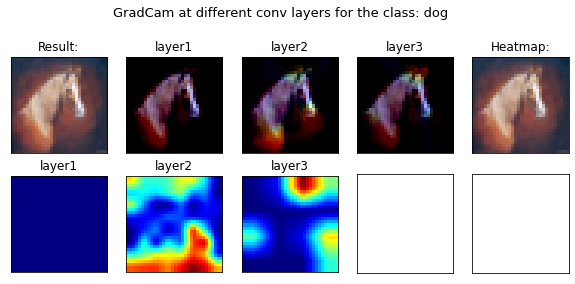

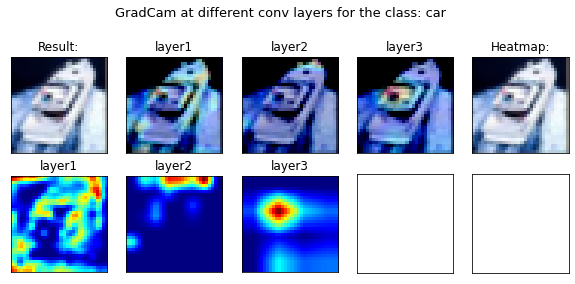

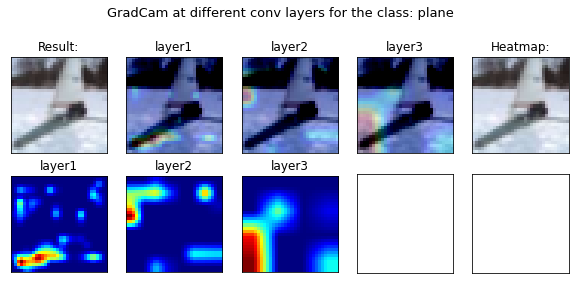

In [52]:
incorrect_pred_imgs = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
viz_cam(torch.stack(incorrect_pred_imgs), target_layers, metric="incorrect")